In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [90]:
df = pd.read_csv("rendement_mais.csv", index_col=False)
df.head()

,SURFACE_HA,TYPE_SOL,ENGRAIS_KG_HA,PRECIPITATIONS_MM,TEMPERATURE_C,RENDEMENT_T_HA
0,7,Limoneux,56,124,21,10.759827
1,4,Limoneux,144,97,28,5.824879
2,8,Limoneux,157,81,21,7.842204
3,5,Argileux,123,106,17,10.560973
4,7,Sableux,88,149,20,11.905060


# Etape 1 : Compréhension du problème

### 1.1. Description des variables disponibles

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SURFACE_HA         1000 non-null   int64  
 1   TYPE_SOL           1000 non-null   object 
 2   ENGRAIS_KG_HA      1000 non-null   int64  
 3   PRECIPITATIONS_MM  1000 non-null   int64  
 4   TEMPERATURE_C      1000 non-null   int64  
 5   RENDEMENT_T_HA     1000 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 47.0+ KB


In [92]:
df.describe()

,SURFACE_HA,ENGRAIS_KG_HA,PRECIPITATIONS_MM,TEMPERATURE_C,RENDEMENT_T_HA
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.898000,126.671000,99.693000,22.154000,7.378419
std,2.603916,44.936511,28.581702,4.322843,2.569991
min,1.000000,50.000000,50.000000,15.000000,3.000276
25%,3.000000,88.000000,75.000000,18.000000,5.126695
50%,5.000000,127.000000,100.000000,22.000000,7.349138
75%,7.000000,167.000000,124.000000,26.000000,9.558181
max,9.000000,199.000000,149.000000,29.000000,11.996019


### 1.2. Formulez clairement le problème métier.

L'objectif est de modéliser la relation entre les facteurs agronomiques (type de sol, engrais, précipitations, température, surface cultivée) et le rendement du maïs afin de maximiser la production tout en optimisant l'utilisation des ressources (engrais, irrigation, choix de la parcelle).

### 1.3. Identifiez la variable cible et les variables explicatives.

- Le jeu de données contient six variables :

    - Variable cible (à prédire) :

        - rendement_t/ha : Rendement du maïs en tonnes par hectare.

    - Variables explicatives (facteurs influençant le rendement) :

        - surface_ha : Surface totale cultivée en hectares.

        - type_sol : Type de sol parmi trois catégories (argileux, sableux, limoneux).

        - engrais_kg/ha : Quantité d'engrais appliquée en kg par hectare.

        - precipitations_mm : Précipitations moyennes mensuelles en millimètres.

        - temperature_C : Température moyenne mensuelle en degrés Celsius.

###  Problématique centrale
- La ferme cherche à répondre à la question suivante :Comment optimiser l’utilisation des ressources (engrais, surface cultivée, irrigation, etc.) en fonction des conditions climatiques et du type de sol afin de maximiser le rendement du maïs ? Cela implique plusieurs sous-problèmes :
    - Quel est l’impact de chaque variable sur le rendement ?
    - Existe-t-il un seuil optimal d’engrais au-delà duquel il n’y a plus d’amélioration ?
    - Comment les conditions climatiques influencent-elles la production ?
    - Le type de sol joue-t-il un rôle déterminant dans les rendements obtenus ?

# Etape 2 : Analyse statistique descriptive

### 2.1 Mesures de tendance centrale

In [93]:
# Calculez la moyenne, médiane, et mode du rendement.
moyenne = df["RENDEMENT_T_HA"].mean()
mediane = df["RENDEMENT_T_HA"].median()
mode = df["RENDEMENT_T_HA"].mode()[0]

In [94]:
print(f"Moyenne du rendement: {moyenne:.2f}")
print(f"Médiane du rendement: {mediane:.2f}")
print(f"Mode du rendement: {mode:.2f}")

Moyenne du rendement: 7.38
Médiane du rendement: 7.35
Mode du rendement: 3.00


### 2.2 Mesures de dispersion

In [95]:
# Calculez l'écart-type, variance, et étendue du rendement.
std_dev = df["RENDEMENT_T_HA"].std()
variance = df["RENDEMENT_T_HA"].var()
range_rendement = df["RENDEMENT_T_HA"].max() - df["RENDEMENT_T_HA"].min()

In [96]:
print(f"Écart-type du rendement: {std_dev:.2f}")
print(f"Variance du rendement: {variance:.2f}")
print(f"Étendue du rendement: {range_rendement:.2f}")

Écart-type du rendement: 2.57
Variance du rendement: 6.60
Étendue du rendement: 9.00


### 2.3 Visualisation des données

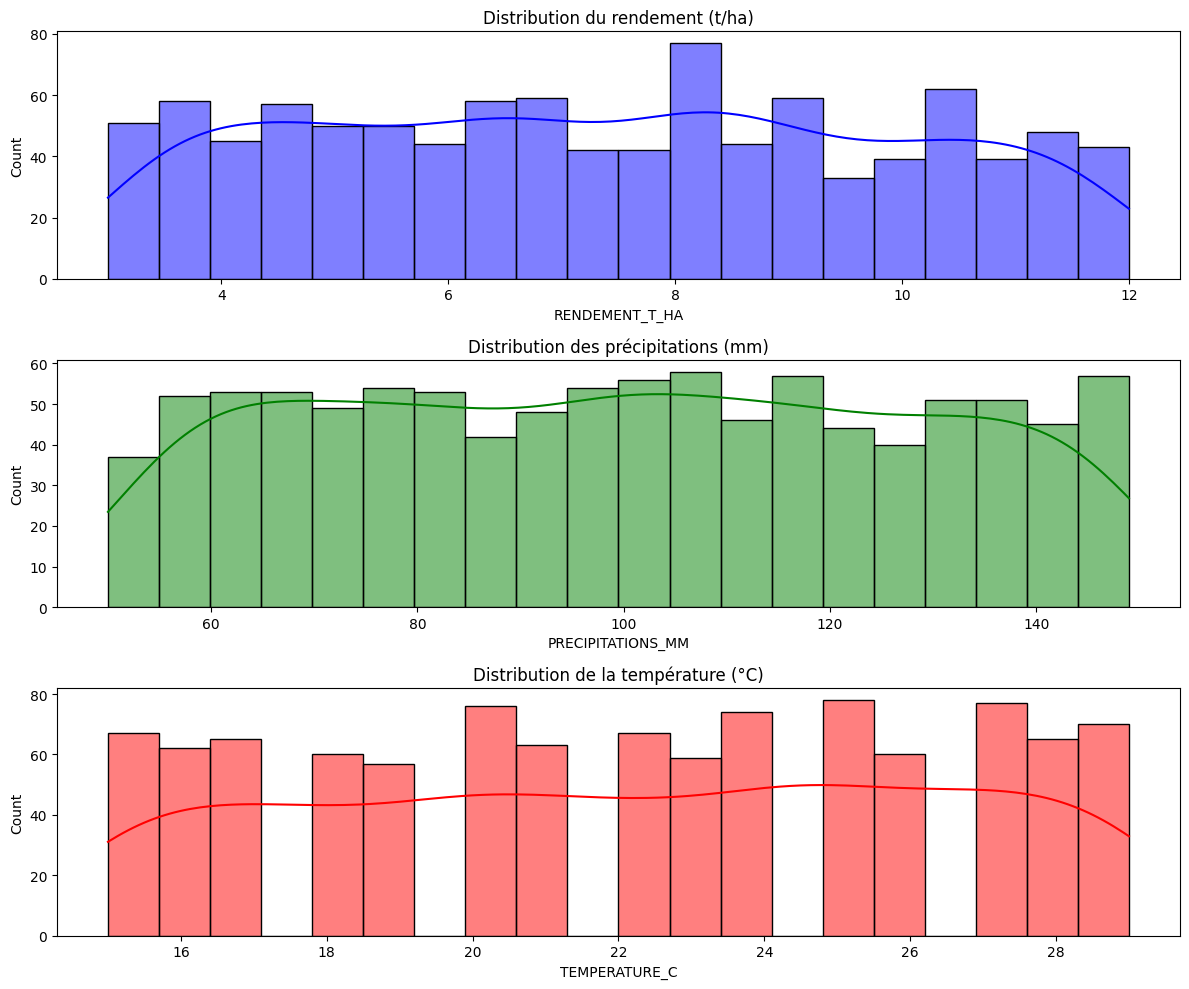

In [97]:
# Créez des histogrammes pour le rendement, les précipitations, et la température.
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Histogrammes
sns.histplot(df["RENDEMENT_T_HA"], bins=20, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution du rendement (t/ha)")

sns.histplot(df["PRECIPITATIONS_MM"], bins=20, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribution des précipitations (mm)")

sns.histplot(df["TEMPERATURE_C"], bins=20, kde=True, ax=axes[2], color="red")
axes[2].set_title("Distribution de la température (°C)")

plt.tight_layout()
plt.show()

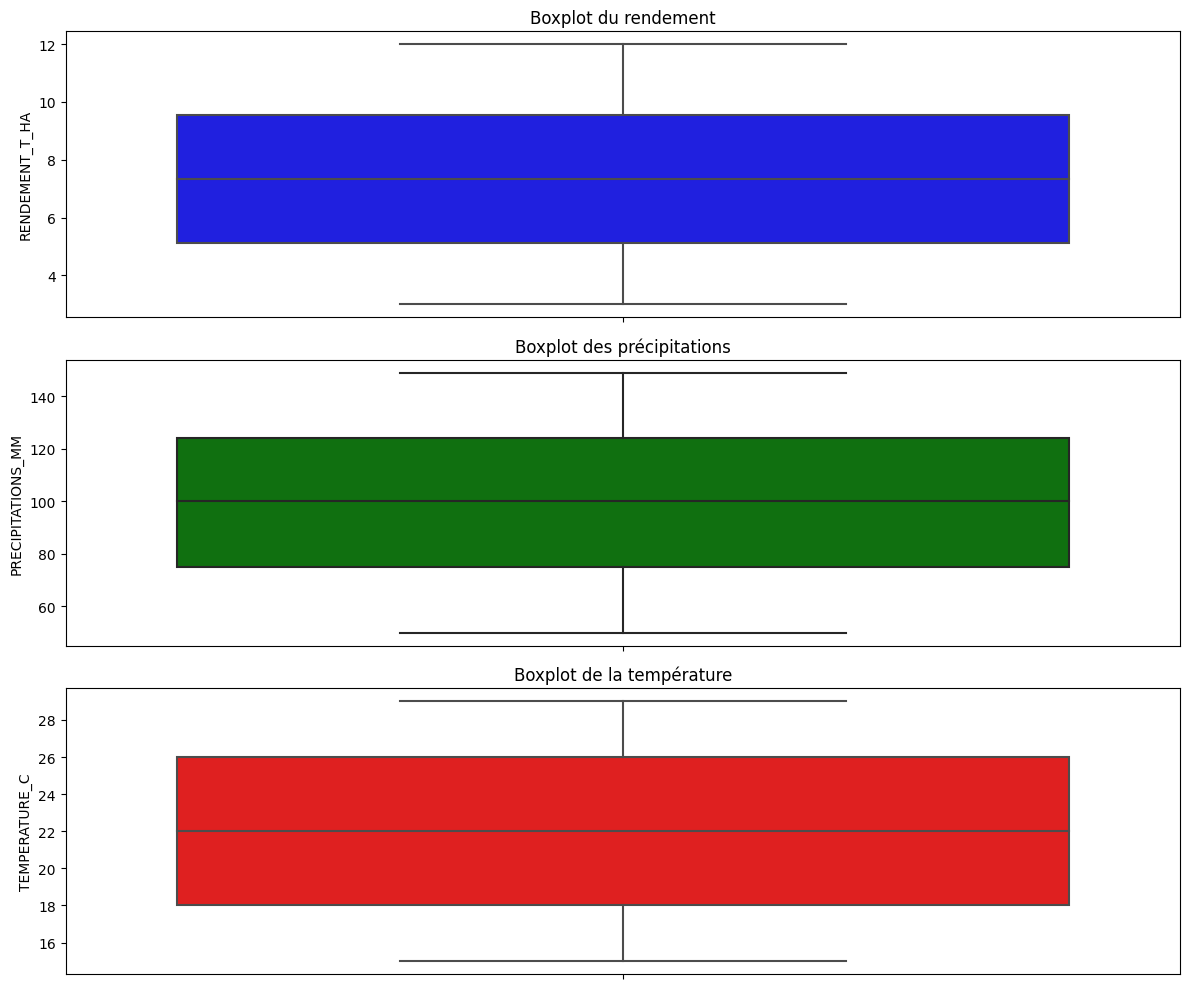

In [98]:
# Affichez des boxplots pour identifier d’éventuels outliers.
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

sns.boxplot(y=df["RENDEMENT_T_HA"], ax=axes[0], color="blue")
axes[0].set_title("Boxplot du rendement")

sns.boxplot(y=df["PRECIPITATIONS_MM"], ax=axes[1], color="green")
axes[1].set_title("Boxplot des précipitations")

sns.boxplot(y=df["TEMPERATURE_C"], ax=axes[2], color="red")
axes[2].set_title("Boxplot de la température")

plt.tight_layout()
plt.show()

### 2.4 Corrélations

In [99]:
# Calculez la matrice de corrélation entre les variables numériques.
corr_matrix = df.drop(columns=["TYPE_SOL"]).corr()
print("\nMatrice de corrélation:\n", corr_matrix)


Matrice de corrélation:
                    SURFACE_HA  ENGRAIS_KG_HA  PRECIPITATIONS_MM  \
SURFACE_HA           1.000000       0.014786           0.025900   
ENGRAIS_KG_HA        0.014786       1.000000          -0.010348   
PRECIPITATIONS_MM    0.025900      -0.010348           1.000000   
TEMPERATURE_C       -0.005717      -0.028524           0.023692   
RENDEMENT_T_HA       0.009141       0.012368          -0.065479   

                   TEMPERATURE_C  RENDEMENT_T_HA  
SURFACE_HA             -0.005717        0.009141  
ENGRAIS_KG_HA          -0.028524        0.012368  
PRECIPITATIONS_MM       0.023692       -0.065479  
TEMPERATURE_C           1.000000        0.013166  
RENDEMENT_T_HA          0.013166        1.000000  


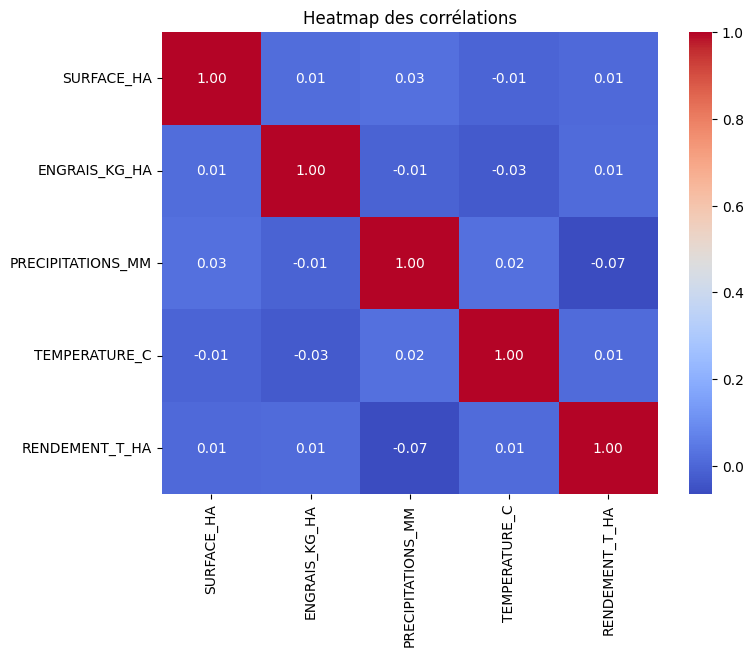

In [100]:
# Affichez une heatmap pour visualiser les corrélations.
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap des corrélations")
plt.show()

### Quelles variables semblent avoir le plus d’impact sur le rendement ?

- Les corrélations sont faibles ce qui implique qu'un facteur important manque
- La surface cultivée, la quantité d’engrais utilisée ainsi que la température moyenne semblent influencer positivement le rendement du maïs de manière similaire. Une augmentation de l’un de ces facteurs est généralement associée à une hausse du rendement, ce qui indique qu’ils jouent un rôle clé dans l’optimisation de la production.

- En revanche, les précipitations semblent avoir l’effet négatif le plus marqué sur le rendement. Une quantité excessive de pluie pourrait entraîner des conditions défavorables, comme un lessivage des nutriments du sol, une saturation en eau nuisant au développement des racines ou encore une augmentation des maladies fongiques, ce qui pourrait expliquer cette corrélation négative.

# Etape 3 : Analyse de la variance (ANOVA)

### 3.1 Hypothèses

- H0 : Le type de sol n’influence pas le rendement.
- H1 : Le type de sol influence le rendement.

### 3.2 Test ANOVA

In [101]:
# Réalisez une ANOVA sur le type de sol.
groupes = [df[df["TYPE_SOL"] == sol]["RENDEMENT_T_HA"] for sol in df["TYPE_SOL"].unique()]
anova_result = stats.f_oneway(*groupes)

print(f"F-statistique: {anova_result.statistic:.2f}")
print(f"p-value: {anova_result.pvalue:.4f}")

F-statistique: 1.36
p-value: 0.2582


In [102]:
# Interprétez la p-value obtenue.
alpha = 0.05
if anova_result.pvalue < alpha:
    print("Le type de sol a une influence significative sur le rendement (on rejette H0).")
else:
    print("Le type de sol n'a pas d'influence significative sur le rendement (on ne rejette pas H0).")

Le type de sol n'a pas d'influence significative sur le rendement (on ne rejette pas H0).


### Le type de sol a-t-il une influence significative sur le rendement ?

- Non, Le type de sol n'a pas d'influence significative sur le rendement. Autrement dit, les différences observées dans le rendement selon le type de sol pourraient être dues au hasard plutôt qu'à un effet réel du type de sol.

# Etape 4 : Modélisation

### 4.1 Séparation des données

In [103]:
# Encodage du type de sol
le = LabelEncoder()
df["TYPE_SOL"] = le.fit_transform(df["TYPE_SOL"])

In [104]:
# Séparation des données
X = df.drop(columns=["RENDEMENT_T_HA"])
y = df["RENDEMENT_T_HA"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
# Normalisation des variables continues
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4.2 Création du modèle

In [106]:
# Définition des modèles
models = {
    "Régression Linéaire": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=50, random_state=42),
    "SVR": SVR(kernel="rbf"),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=3)
}

In [107]:
# Entraînement des modèles
trained_models = {}
for name, model in models.items():
    model.fit(X_train_scaled if name == "SVR" else X_train, y_train)
    trained_models[name] = model  # Stocker les modèles entraînés

In [108]:
import keras

# Définition du réseau de neurone
dl_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Première couche cachée
    keras.layers.Dense(32, activation='relu'),  # Deuxième couche cachée
    keras.layers.Dense(16, activation='relu'),  # Troisième couche cachée
    keras.layers.Dense(1, activation='linear')  # Couche de sortie (prédiction du rendement)
])

# Compilation du modèle
dl_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Affichage du résumé du modèle
dl_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                384       
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


In [109]:
# Entraînement du modèle
history = dl_model.fit(X_train_scaled, y_train,
                    epochs=100, batch_size=16,
                    validation_data=(X_test_scaled, y_test),
                    verbose=1)


Epoch 1/100
50/50 [==============================] - 1s 9ms/step - loss: 53.2657 - mae: 6.8051 - val_loss: 36.4481 - val_mae: 5.5228
Epoch 2/100
50/50 [==============================] - 0s 5ms/step - loss: 18.7859 - mae: 3.5426 - val_loss: 7.4944 - val_mae: 2.2437
Epoch 3/100
50/50 [==============================] - 0s 5ms/step - loss: 8.0956 - mae: 2.3763 - val_loss: 7.0473 - val_mae: 2.1885
Epoch 4/100
50/50 [==============================] - 0s 5ms/step - loss: 7.8593 - mae: 2.3425 - val_loss: 7.1925 - val_mae: 2.2259
Epoch 5/100
50/50 [==============================] - 0s 5ms/step - loss: 7.7399 - mae: 2.3345 - val_loss: 6.9534 - val_mae: 2.1834
Epoch 6/100
50/50 [==============================] - 0s 5ms/step - loss: 7.7365 - mae: 2.3310 - val_loss: 6.9122 - val_mae: 2.1813
Epoch 7/100
50/50 [==============================] - 0s 5ms/step - loss: 7.5360 - mae: 2.3066 - val_loss: 6.9107 - val_mae: 2.1942
Epoch 8/100
50/50 [==============================] - 0s 5ms/step - loss: 7.4961 

50/50 [==============================] - 0s 6ms/step - loss: 5.6392 - mae: 2.0199 - val_loss: 7.0541 - val_mae: 2.2212
Epoch 64/100
50/50 [==============================] - 0s 5ms/step - loss: 5.6245 - mae: 2.0094 - val_loss: 7.0810 - val_mae: 2.2187
Epoch 65/100
50/50 [==============================] - 0s 6ms/step - loss: 5.6699 - mae: 2.0103 - val_loss: 7.0787 - val_mae: 2.2208
Epoch 66/100
50/50 [==============================] - 0s 5ms/step - loss: 5.6128 - mae: 2.0157 - val_loss: 7.3088 - val_mae: 2.2349
Epoch 67/100
50/50 [==============================] - 0s 5ms/step - loss: 5.5924 - mae: 1.9980 - val_loss: 6.9965 - val_mae: 2.2217
Epoch 68/100
50/50 [==============================] - 0s 6ms/step - loss: 5.5842 - mae: 2.0004 - val_loss: 7.2445 - val_mae: 2.2381
Epoch 69/100
50/50 [==============================] - 0s 5ms/step - loss: 5.5892 - mae: 1.9982 - val_loss: 7.2066 - val_mae: 2.2371
Epoch 70/100
50/50 [==============================] - 0s 5ms/step - loss: 5.5643 - mae: 1

### 4.3 Évaluation du modèle

In [110]:
# Fonction d'évaluation
def eval_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"Modèle": model_name, "MAE": mae, "RMSE": rmse, "R²": r2}

In [111]:
# Stocker les résultats d'évaluation
results = []
for name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled if name == "SVR" else X_test)
    results.append(eval_model(y_test, y_pred, name))

In [112]:
# Prédictions sur le test set
y_pred_ann = dl_model.predict(X_test_scaled)
results.append(eval_model(y_test, y_pred, "MLP"))

7/7 [==============================] - 0s 3ms/step


In [113]:
# Convertir en DataFrame
results_df = pd.DataFrame(results)
print(results_df)

                Modèle       MAE      RMSE        R²
0  Régression Linéaire  2.072889  2.437049 -0.007117
1        Random Forest  2.105405  2.535882 -0.090459
2    Gradient Boosting  2.079283  2.479205 -0.042260
3                  SVR  2.198404  2.580716 -0.129358
4        KNN Regressor  2.237921  2.721893 -0.256300
5                  MLP  2.237921  2.721893 -0.256300


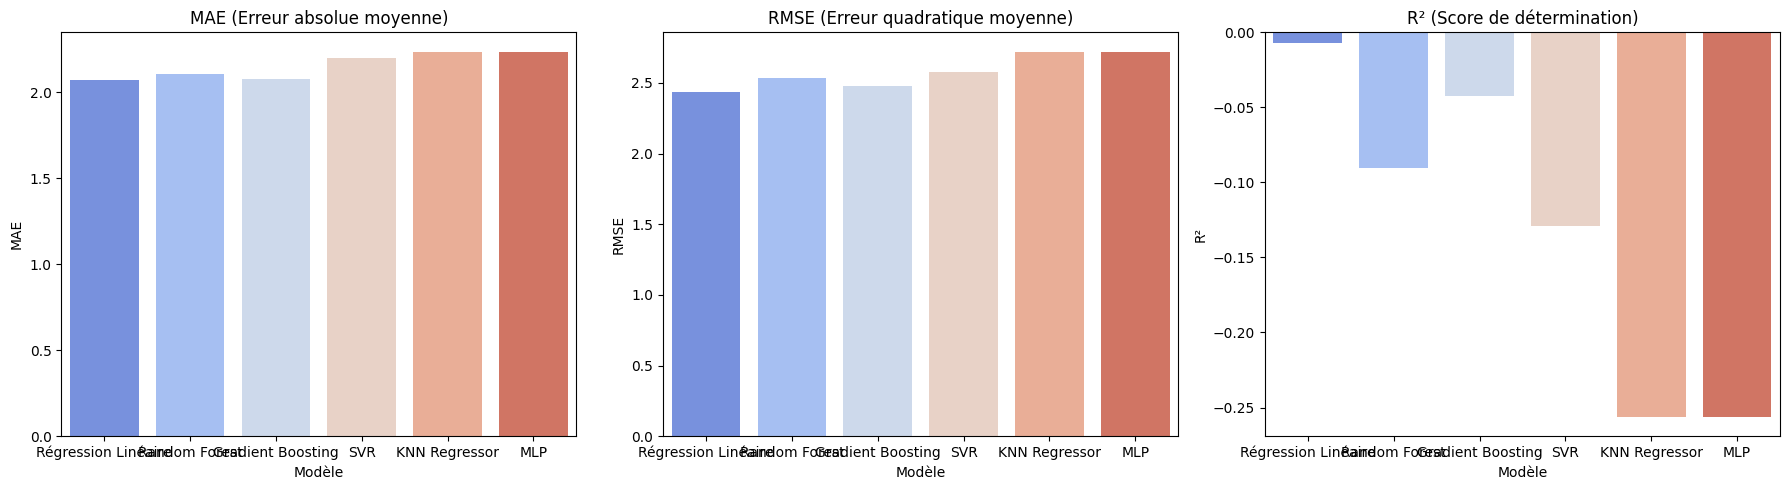

In [114]:
#  Graphiques des performances
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Graphique MAE
sns.barplot(data=results_df, x="Modèle", y="MAE", ax=axes[0], palette="coolwarm")
axes[0].set_title("MAE (Erreur absolue moyenne)")

# Graphique RMSE
sns.barplot(data=results_df, x="Modèle", y="RMSE", ax=axes[1], palette="coolwarm")
axes[1].set_title("RMSE (Erreur quadratique moyenne)")

# Graphique R²
sns.barplot(data=results_df, x="Modèle", y="R²", ax=axes[2], palette="coolwarm")
axes[2].set_title("R² (Score de détermination)")

plt.tight_layout()
plt.show()

### Lequel des modèles est-il performant (pourquoi d’après vous) ?

- Le modèle le plus performant semble être la Régression Linéaire :
    - Il a la plus faible erreur (MAE = 2.07, RMSE = 2.44)
    - Son R² est proche de 0 (-0.007), ce qui signifie qu'il ne parvient pas bien à expliquer la variance des données

- Les modèles non linéaires (Random Forest, Gradient Boosting, SVR, KNN) n'améliorent pas les résultats
    - Random Forest et Gradient Boosting ont un R² négatif, ce qui signifie qu'ils performent moins bien qu'une simple moyenne
    - Le modèle KNN est le moins performant, avec une erreur plus élevée et un R² très bas (-0.249)

- Les données pourraient ne pas contenir suffisamment d’informations prédictives sur le rendement.
    - L’analyse exploratoire montrait que certaines variables avaient une faible corrélation avec le rendement.
    - Peut-être qu’un facteur important manque (ex. qualité du sol, maladies des cultures, pratiques agricoles précises).
- Les relations entre les variables ne sont peut-être pas linéaires.
    - Les modèles comme la Régression Linéaire supposent une relation linéaire entre les variables et le rendement.
    - Pourtant, l’impact des précipitations, de l’engrais ou de la température pourrait être plus complexe (effets seuils, interactions).

# Etape 5 : Interprétation et recommandations

### 5.1 Analysez l'importance des variables.

- Surface cultivée, quantité d’engrais et température moyenne
  - Ces facteurs ont un effet positif sur le rendement.
  - Augmenter ces variables peut améliorer la production, mais jusqu’à un certain seuil (loi des rendements décroissants).
  - La température a un impact, mais elle est difficilement contrôlable directement.

- Précipitations
  - Effet négatif marqué sur le rendement.
  - Des précipitations excessives peuvent provoquer un lessivage des nutriments, une asphyxie des racines ou favoriser des maladies.
  - Une gestion efficace du drainage et de l’irrigation pourrait atténuer cet impact.

- Type de sol
  - N’a pas d’influence significative d’après les analyses actuelles.
  - Il est possible que cette variable ne soit pas bien caractérisée (ex. manque d’indicateurs sur la structure ou la fertilité réelle du sol).

### 5.2 Proposez des recommandations concrètes pour augmenter le rendement (ex : ajuster l’engrais, choisir un type de sol particulier, etc.).

- Optimisation de l’utilisation des engrais
  - Tester différents dosages et modes d’application (ex. fractionnement des apports) pour maximiser leur efficacité.
  - Introduire des amendements organiques pour améliorer la rétention des nutriments et réduire le lessivage.

- Gestion de l’eau et des précipitations
  - Mettre en place un système de drainage pour éviter l’engorgement en cas de pluies excessives.
  - Envisager l’irrigation en cas de déficit hydrique, notamment durant les phases critiques de développement du maïs.

- Amélioration des pratiques culturales
  - Tester différentes dates de semis pour s’adapter aux conditions climatiques.
  - Introduire des rotations culturales pour préserver la fertilité du sol et limiter l’érosion.

- Exploration de nouvelles variables
  - Ajouter des données sur la qualité du sol (ex. pH, taux de matière organique, capacité de rétention d’eau).
  - Étudier l’impact des pratiques agricoles (ex. densité de semis, type d’engrais, techniques de labour).

- Analyser les maladies et ravageurs qui pourraient impacter les rendements.

### 5.3 Identifiez les limites du modèle et proposez des pistes d’amélioration.

- Faible pouvoir explicatif du modèle (R² proche de 0)
  - Les données actuelles ne suffisent pas à bien prédire le rendement.
  - Il est essentiel de collecter d’autres variables plus représentatives de la réalité agricole.

### Quelles décisions la ferme pourrait-elle prendre pour optimiser sa production ?

- Investir dans une meilleure collecte de données pour affiner la compréhension des facteurs influençant le rendement.

- Mettre en place des tests agronomiques pour évaluer l’impact de différentes pratiques sur la production.

- Optimiser l’irrigation et le drainage afin de limiter l’impact négatif des précipitations.

- Ajuster les doses d’engrais en fonction des besoins réels et des conditions météorologiques.

- Expérimenter avec les dates de semis et d’autres pratiques pour identifier celles qui maximisent le rendement.